Learning pytorch using CAFA5 as an example.

Here we implement simple neural network (multi-layer perceptron) in pytorch, train it on CAFA5 data to submit predictions

Using already computed emebdding for the proteins sequences created by Andrey Shevtsov esm2-model: ( https://www.kaggle.com/competitions/cafa-5-protein-function-prediction/discussion/406168 - Might use multiple embedding models in future work.

This model was prepared especially for use in this Cafa5 task and may be more relevant than the previously used T5 model

**Ongoing task:** Change parameters for the neural network and try to improve the score.
Later on try understand/modify/apply to CAFA5:

https://www.kaggle.com/code/romanvinogradov/cafa-mlp-inference

Idea by "tmp" - use cnn for such types of data, but make a first dense layer which arranges data to be suitable for cnn: https://www.kaggle.com/competitions/lish-moa/discussion/202256

Related ideas: Senkin13: https://www.kaggle.com/code/senkin13/2nd-place-gru-cite , modifications by Dmitry Ershov: https://www.kaggle.com/code/bejeweled/rotate-2nd-place-cite-2d-cnn and other 3 notebooks by him (top-scored on Kaggle Open Problems (late submissions)): https://www.kaggle.com/competitions/open-problems-multimodal/code?competitionId=38128&sortBy=scoreDescending

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import time
t0start = time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/23468234/train_ids_esm2_t33_650M_UR50D.npy
/kaggle/input/23468234/test_ids_esm2_t33_650M_UR50D.npy
/kaggle/input/23468234/test_embeds_esm2_t33_650M_UR50D.npy
/kaggle/input/23468234/train_embeds_esm2_t33_650M_UR50D.npy
/kaggle/input/cafa5-features-etc/T5_train_embeds_float32.npy
/kaggle/input/cafa5-features-etc/Y_1499_sparse.npz
/kaggle/input/cafa5-features-etc/Y_31466_labels.npy
/kaggle/input/cafa5-features-etc/df_Y_1499.csv
/kaggle/input/cafa5-features-etc/train_ids.npy
/kaggle/input/cafa5-features-etc/df_Levenshtein_distance_100_features_train.csv
/kaggle/input/cafa5-features-etc/T5_test_embeds_float32.npy
/kaggle/input/cafa5-features-etc/df_scores_with_descriptions.csv
/kaggle/input/cafa5-features-etc/df_train_eda.csv
/kaggle/input/cafa5-features-etc/Y_1499.npy
/kaggle/input/cafa5-features-etc/df_terms_counts_weights_names_etc.csv
/kaggle/input/cafa5-features-etc/df_Levenshtein_distance_100_features_test.csv
/kaggle/input/cafa5-features-etc/test_ids.npy
/kaggle/input/c

In [2]:
%%capture 
!pip install torchmetrics

In [3]:
%%capture
!pip install torchsummary

In [4]:
## https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary#Load-train-features---precalculated-embeddings-for-the-proteins
import os
import gc
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()
import torch
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics import AUROC,F1Score
from torchmetrics.classification import BinaryF1Score
from torchsummary import summary as torchsummary

**Metrics**
"torchmetrics" - is additional package to pytorch - contains many metrics which basic pytorch does not

Pay attention: input arguments should be torch.tensor not lists or np.arrays

Pay attention: auc function - order of arguments is opposite to sklearn rocauc function, and on some other details of intialization - different from the sklearn syntax. The syntax is auroc - not auCroc - as one may expect

Funny note: same losses e.g. BCE can be imported from different modelues with differnt names, but they are the same - e.g. torch.nn.functional under the name binary_cross_entropy and import torch.nn as nn - as nn.BCELoss()

In [5]:
import torch.nn.functional as F

# F.binary_cross_entropy(out, labels)   # Calculate loss
s =  F.binary_cross_entropy( torch.tensor([0.,1,0.5]), torch.tensor([0,1.,1] ) )  # Important to have float - on [0,1] it crashes - "Long not supported"
print( s )
print( s.grad_fn )

import torch.nn as nn
preds = torch.tensor([0.,1,0.5])
target = torch.tensor([0,1.,1])
loss_func = nn.BCELoss()
s = loss_func(preds, target )
print( s )
print( s.grad_fn )

import torch.nn as nn
preds = torch.tensor([0.,1,0.5])
target = torch.tensor([0,1.,1])
loss_func  = torch.nn.MSELoss() 
s = loss_func(preds, target )
print( s )
print( s.grad_fn )


from torchmetrics import AUROC,F1Score

auroc = AUROC(task = 'binary')
# order of arguments is different from the sklearn : sklearn - y_true, y_score, while in pytorch - y_score, y_true
# Also we first need to initialize  aucroc = AUROC(task = 'binary'), and only then apply  
s = auroc(torch.tensor([0,.6,0]), torch.tensor([0,1,1]) ) 
print('\n AUC')
print( s )
print( s.grad_fn )
s = auroc(torch.tensor([0,.01,0.02,0]), torch.tensor([0,1,1,1]) ) 
print( s )
s = auroc(torch.tensor([0,.1,0.2,0]), torch.tensor([0,1,1,1]) ) 
print( s )
print()

target = torch.tensor([0, 1, 1, 0, 1, 1])
preds = torch.tensor([0, 1, 1, 0, 0, 1])
f1 = F1Score(task="multiclass", num_classes=2)
s = f1(preds, target)
print( s )
print( s.grad_fn )

from torchmetrics.classification import BinaryF1Score
f1 = BinaryF1Score(threshold=0.5, multidim_average= 'global'  )
s = f1(preds, target)
print( s )
print( s.grad_fn )

tensor(0.2310)
None
tensor(0.2310)
None
tensor(0.0833)
None

 AUC
tensor(0.7500)
None
tensor(0.8333)
tensor(0.8333)

tensor(0.8333)
None
tensor(0.8571)
None


**How multi-target cases are computed**
Many metrics support cases of many tartgets, i.e. Y_pred and Y_true are both matrices : n_samples x n_targets

There is NO such support in e.g. sklearn.metrics - where we typically work with single target tasks.

There are several ways how standard metrics can be extended to multi-target cases, and for some metrics there is a parameter "multidim_average", taking values 'global' / 'samplewise' which control what way to choose.

The other detail - for the metrics like F1 predictions expected to be in [0,1] interval , if this fail, then torch and sklearn metrics may disagree. In standard case the agree as shown below.

In [6]:
target =  torch.tensor( (np.random.randn(100,10)>0).astype(float) )
preds = torch.tensor( np.clip( np.random.randn(100,10) + 0.5, 0 ,1) )

#  multidim_average= 'global'
print( " multidim_average= 'global'   ", 'Scalar will be returned')
f1 = BinaryF1Score(threshold=0.5, multidim_average= 'global'  )
s = f1(preds, target)
print(s.shape)
print( s )

print()
print(" multidim_average= 'samplewise'  ", 'vector of values for each sample will be returned')
f1 = BinaryF1Score(threshold=0.5, multidim_average= 'samplewise'  )
s = f1(preds, target)
print(s.shape)
print(s.mean() )
print( s )


print()
print()
print('Implement the same with sklearn')
from sklearn.metrics import f1_score
print('Global case ')
s = f1_score( target.numpy().ravel() ,   preds.numpy().ravel() >= 0.5  )
print(np.round(s,4))

print('Samplewise case:')
l = [ f1_score( target.numpy()[i,:], preds.numpy()[i,:] >= 0.5 ) for i in range(preds.shape[0]) ]
s = np.mean(l)
print( np.round(s,4))

 multidim_average= 'global'    Scalar will be returned
torch.Size([])
tensor(0.4985)

 multidim_average= 'samplewise'   vector of values for each sample will be returned
torch.Size([100])
tensor(0.4674)
tensor([0.5000, 0.7500, 0.3333, 0.6667, 0.0000, 0.0000, 0.2857, 0.6667, 0.4000,
        0.3636, 0.6000, 0.4615, 0.6000, 0.5714, 0.6667, 0.7692, 0.2857, 0.4000,
        0.6667, 0.2000, 0.5000, 0.3636, 0.5000, 0.6000, 0.3333, 0.7143, 0.5000,
        0.0000, 0.6667, 0.4000, 0.5000, 0.4000, 0.5455, 0.6154, 0.6000, 0.2222,
        0.4444, 0.2857, 0.0000, 0.2222, 0.5455, 0.6000, 0.5714, 0.0000, 0.8333,
        0.6154, 0.2000, 0.5000, 0.6154, 0.6154, 0.4000, 0.4000, 0.2500, 0.2857,
        0.4444, 0.4444, 0.5455, 0.4000, 0.9091, 0.5000, 0.5714, 0.5714, 0.6154,
        0.2500, 0.7273, 0.4000, 0.7692, 0.8235, 0.4444, 0.0000, 0.6667, 0.5000,
        0.8571, 0.4444, 0.2500, 0.6000, 0.2222, 0.3333, 0.5455, 0.5714, 0.0000,
        0.6667, 0.7500, 0.2222, 0.2857, 0.5714, 0.5714, 0.7500, 0.6154, 0.444

In [7]:
%%time
s = auroc(preds, target ) 
print( s )


from sklearn.metrics import roc_auc_score
s = roc_auc_score(target.numpy().ravel() , preds.numpy().ravel()) 
print( np.round(s,4) )

tensor(0.4935)
0.4935
CPU times: user 7.17 ms, sys: 847 µs, total: 8.02 ms
Wall time: 15.8 ms


^doesn't work- cannot apply metrics to list/np.arrays etc - we can apply metrics to pytorch tensors only

In [8]:
try: 
    F.binary_cross_entropy( np.array([0.,1.,0.5]), np.array([0.,1.,1.] ) )
    F.binary_cross_entropy( [0.,1.,0.5] ,  [0.,1.,1.]  )
    aucroc(([0,.6,0]), ([0,1,1]) )
    aucroc(np.array([0,.6,0]), np.array([0,1,1]) )
except Exception as inst:
    print(type(inst))    # the exception type
    print(inst.args)     # arguments stored in .args
    print(inst)      

<class 'TypeError'>
("'int' object is not callable",)
'int' object is not callable


Loading precalulcated features - embeddings and targets transformed in 0,1 multi-target task.

We use already computed emebdding for the proteins sequences 'esm2-model' - thanks to Andrey Shevtsov 

We load targets matrix "Y" which contains NOT all the CAFA5 targets but only top 1499. That is quite enough to get not so bad score. Note: original input file text describing targets have been trasnformed to np.array Y. See the notebook https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary for details.

(142246, 2560)
[[-0.00693172  0.00793555  0.00273201]
 [-0.00823162 -0.07488033 -0.00828702]]
(142246,)
['P20536' 'O73864' 'O95231' 'A0A0B4J1F4' 'P54366' 'P33681' 'P77596'
 'Q16787' 'Q59VP0' 'P13508' 'Q96S79' 'Q9VSA3' 'O94652' 'P35669' 'Q5MNZ6']
(1499,)
['GO:0005575' 'GO:0008150' 'GO:0110165' 'GO:0003674' 'GO:0005622'
 'GO:0009987' 'GO:0043226' 'GO:0043229' 'GO:0005488' 'GO:0043227'
 'GO:0005737' 'GO:0043231' 'GO:0005515' 'GO:0065007' 'GO:0050789'
 'GO:0050794' 'GO:0050896' 'GO:0008152' 'GO:0032501' 'GO:0005634']
(142246, 1499)
[[0. 1. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


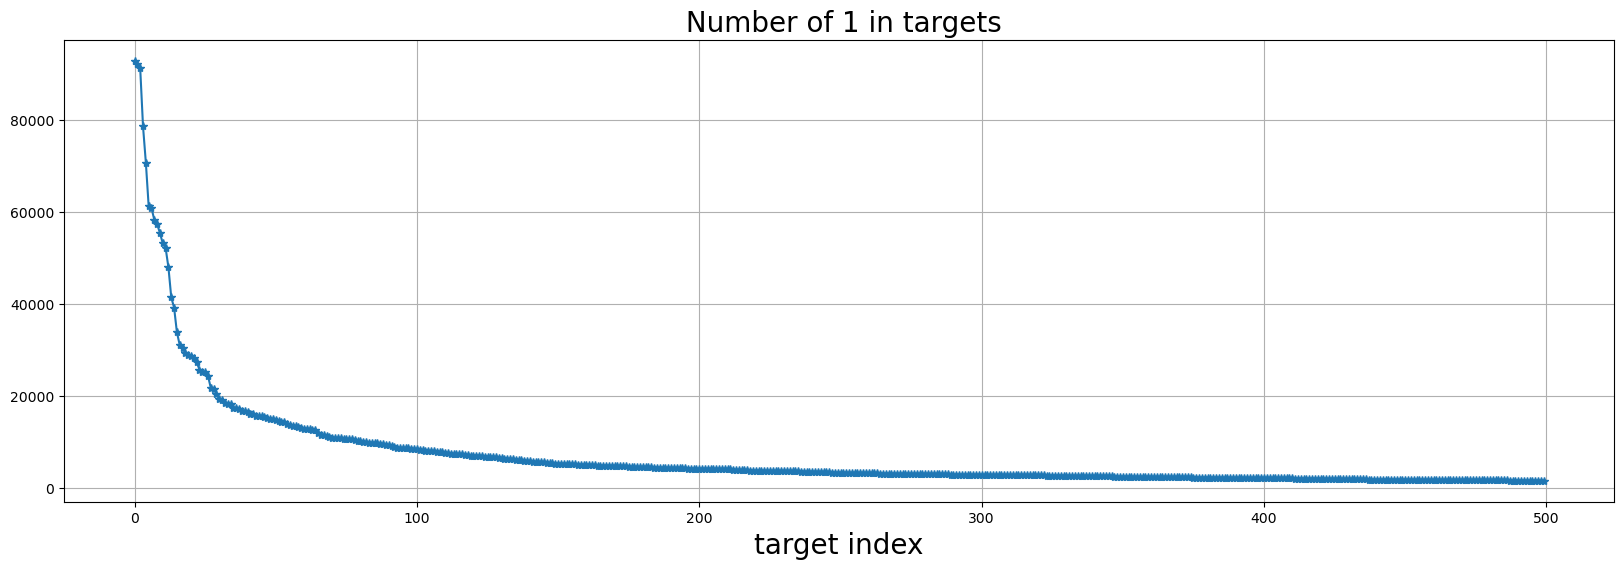

CPU times: user 1.35 s, sys: 5.8 s, total: 7.15 s
Wall time: 54.8 s


In [9]:
%%time 
################ load  features #########################

fn = '/kaggle/input/4637427/train_embeds_esm2_t36_3B_UR50D.npy'
X = np.load(fn).astype(np.float32)
print(X.shape)
print(X[:2,:3])
prot_ids  = np.load('/kaggle/input/4637427/train_ids_esm2_t36_3B_UR50D.npy')
print(prot_ids.shape)
print(prot_ids[:15])

############################ load targets and their ids  ######################################
fn = '/kaggle/input/cafa5-features-etc/Y_1499_labels.npy'
Y_labels = np.load(fn)
print(Y_labels.shape)
print(Y_labels[:20])
# %%time 
fn = '/kaggle/input/cafa5-features-etc/Y_1499.npy'
Y = np.load(fn)
print(Y.shape)
print(Y[:20])
# %%time
if 1:
    v = Y.sum(axis = 0)
    plt.figure(figsize = (20,6))
    plt.plot(v[:500], '*-')
    plt.grid()
    plt.title(' Number of 1 in targets',fontsize = 20 )
    plt.xlabel('target index', fontsize = 20 )
    plt.show()

    
# fn_train_terms = '/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv'
# fn_train_taxonomy ='/kaggle/input/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv'

**Define neural network**
This is a simple pytourch NN
It will need to be optimised for Cafa5 in future versions

In [10]:
import torch.nn as nn

In [11]:
class MyModel(nn.Module): # The parent class for the models is nn.Module 
    
    def __init__(self, in_features, out_features): # constructor 
        
        super().__init__() # the constructor of the upper class is first called

        self.in_features = in_features
        self.out_features = out_features

        self.model = nn.Sequential( #  Sequential addition of layers -  multi-layer perceptron 
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, 800),
            nn.ReLU(),

            nn.BatchNorm1d(800),            # nn.Dropout(0.1),
            nn.Linear(800, 600),
            nn.ReLU(),

            nn.BatchNorm1d(600),            # nn.Dropout(0.1),
            nn.Linear(600, 400),
            nn.ReLU(),

            nn.BatchNorm1d(400),
            nn.Linear(400, out_features),
            nn.Sigmoid()
        )

    def forward(self, x): # 
        return self.model(x)

Choose device, CPU or GPU

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Model to deice

In [13]:
model = MyModel(X.shape[1],Y.shape[1])
model.to(device)

MyModel(
  (model): Sequential(
    (0): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=2560, out_features=800, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=800, out_features=600, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=600, out_features=400, bias=True)
    (8): ReLU()
    (9): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=400, out_features=1499, bias=True)
    (11): Sigmoid()
  )
)

In [14]:
try:
    torchsummary(model, XX.size(), batch_size=-1, device= 'cuda')
except    Exception as inst:
    print(type(inst))    # the exception type
    print(inst.args)     # arguments stored in .args
    print(inst)          # __str__ allows args to be printed directly,
                         # but may be overridden in exception subclasse

<class 'NameError'>
("name 'XX' is not defined",)
name 'XX' is not defined


Train test split

In [15]:
%%time 
from sklearn.model_selection import train_test_split

IX_train,IX_val = train_test_split( np.arange(len(X)), train_size=0.7, random_state=42)
print(IX_train.shape,IX_val.shape) 

(99572,) (42674,)
CPU times: user 12.1 ms, sys: 1.53 ms, total: 13.6 ms
Wall time: 13.6 ms


Create X/Y_train, X/Y_val as pytorch tensors and send to device

In [16]:
%%time
X_train = torch.tensor(X[IX_train,:], dtype=torch.float32).to(device)
Y_train = torch.tensor(Y[IX_train,:], dtype=torch.float32).to(device)

X_val = torch.tensor(X[IX_val,:], dtype=torch.float32).to(device)
Y_val = torch.tensor(Y[IX_val,:], dtype=torch.float32).to(device)

print(X_train.shape, Y_train.shape,X_val.shape, Y_val.shape )

torch.Size([99572, 2560]) torch.Size([99572, 1499]) torch.Size([42674, 2560]) torch.Size([42674, 1499])
CPU times: user 1.85 s, sys: 11.7 s, total: 13.5 s
Wall time: 10.6 s


Wrap X,Y into "TensorDataset" and create "DataLoader"

TensorDataset" allows to unify several arrays to work with them as a whole. For example for pair X_train and Y_train we can create "train_dataset" which combines both.

As a next step we create "DataLoader" object from "train_dataset" which automatically take care about batches - see the main training loop of the neural network

In [17]:
# BATCH_SIZE = 5120
# EPOCHS = 50
# LEARNING_RATE = 0.001
# MOMENTUM = 0.9
# OPT_FUNC = torch.optim.Adam

In [18]:
%%time 
BATCH_SIZE = 256

from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# val_dataset = TensorDataset(X_val, Y_val)
# val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

CPU times: user 1.02 ms, sys: 16 µs, total: 1.04 ms
Wall time: 1.05 ms


**Training**

Training Pytorch NNs is relatively simple. Training implements the gradient descent method. Each step updates the weights of the NN to minimize loss function. Pytorch essentially is a blackbox which automatically calculates gradients and user should not care about that part. We just only need to do several steps:

model.train() - turns model into the standard mode when gradients will be computed - it is opposite to "model.eval()"

model.eval() - turns model into the mode when gradients are NOT computed - that is done when we for example want NOT to train model, but just look what we get and evaluate metrics. So when we turn off graidents computate we do not waster resources - speed and RAM on their computation.
with torch.no_grad(): - similar 

1) We need to write loop over epochs, and the inner loop over batches. 

2) Technical step - optimizer.zero_grad() - set gradients to zero for each step 

3) Calcualte model predictions on each batch:   preds = model(x_batch) 

4) Calculate the for that batch:  loss = criterion(preds, y_batch) 

5) loss.backward() - calulation of the gradient (i.e. loss function with respect to weights of the neural network)

6)  optimizer.step() - update the weights along the gradients

In [19]:
import datetime
current_datetime = datetime.datetime.now()

print("Current datetime:", current_datetime)

Current datetime: 2023-08-21 20:22:42.992151


In [20]:
%%time

max_epoch = 15


import time 
t0 = time.time()

from torchmetrics.classification import BinaryF1Score
f1 = BinaryF1Score(threshold=0.25, multidim_average= 'samplewise'  )
from torchmetrics import AUROC
auroc = AUROC(task = 'binary')


print('X.shape, Y.shape', X.shape, Y.shape )
print()

# do not fortget to reinitialize model when you debug the notebook, since otherwise - each time you rerun the current cell 
# - you will update existing weights  - it would be easy to see that starting loss is unexpectdely small 
model = MyModel(X.shape[1],Y.shape[1])
model.to(device)



optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #SGD(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 0.05, 10)
criterion = nn.BCELoss()


df_stat = pd.DataFrame(); IX_stat = -1;
print()
print( str(model))
print()
current_datetime = datetime.datetime.now()
print('Start training NN',current_datetime)
print()
for epoch in range(max_epoch):
    t0_epoch = time.time()
    model.train() # switch model into train mode i.e. allow gradients computation - opposite of model.eval() - no grad computation
    for i_batch, (x_batch, y_batch) in enumerate(train_dataloader): # Loop ove batches
#             x_batch, y_batch = x_batch.to(device), y_batch.to(device) # do we need it ? may be already on device 
        preds = model(x_batch)# Compute predictions only for batch samples 

        optimizer.zero_grad() # technical - set gradients to zero, otherwise they will be accumulated         

        loss = criterion(preds, y_batch) # Compute loss function 
        loss.backward() # Compute gradients
        optimizer.step() # Update NN weights using gradients

        if i_batch % 100 == 0:
            print(f'Epoch: {epoch}, batch: {i_batch},  train loss on batch: {loss.item():12.5f} , time: {time.time() - t0:.1f} ' )

    t0_epoch_train = time.time() - t0_epoch            
    model.eval()
    with torch.no_grad():
        train, y_train = train_dataset.tensors
        # train, y_train = train.to(device), y_train.to(device) # They already should on device, why we need that ?
        preds = model(train)
        preds_train = preds
        loss = criterion(preds, y_train)
        loss1 = loss.item()
        print()
        print(f'Epoch: {epoch} finished,  train loss: {loss.item():12.5f} , time: {time.time() - t0:.1f} seconds ' )
        
        preds = model(X_val)
        preds_val = preds
        loss = criterion(preds, Y_val)
        loss2 = loss.item()
        print(f'Epoch: {epoch} finished,  VALidation loss: {loss.item():12.5f} , time: {time.time() - t0:.1f} seconds ' )
        print()
        
        IX_stat += 1
        df_stat.loc[IX_stat, 'epoch'] = epoch
        df_stat.loc[IX_stat, 'BCE Val'] = loss2
        df_stat.loc[IX_stat, 'BCE Train'] = loss1
        
        #from torchmetrics.classification import BinaryF1Score
        f1 = BinaryF1Score(threshold=0.25, multidim_average= 'samplewise'  )
        s = f1(preds_val, Y_val) # vector of values for each sample
        df_stat.loc[IX_stat, 'F1|0.25 Val'] = s.mean().item()#  average over samples
        s = f1(preds_train, y_train) 
        df_stat.loc[IX_stat, 'F1|0.25 Train'] =  s.mean().item()
        
        #from torchmetrics import AUROC
        auroc = AUROC(task = 'binary')
        s = auroc(preds_val, Y_val) # auroc between flattened arguments 
        df_stat.loc[IX_stat, 'AUC Val'] = s.item()#  average over samples
        s = auroc(preds_train, y_train) # auroc between flattened arguments 
        df_stat.loc[IX_stat, 'AUC Train'] =  s.item()
        
        
        for threshold_for_f1 in [0.2,0.3]:
            #from torchmetrics.classification import BinaryF1Score
            f1 = BinaryF1Score(threshold=threshold_for_f1, multidim_average= 'samplewise'  )
            s = f1(preds_val, Y_val) # vector of values for each sample
            df_stat.loc[IX_stat, 'F1|'+str(threshold_for_f1)+' Val'] = s.mean().item()#  average over samples
            s = f1(preds_train, y_train) 
            df_stat.loc[IX_stat, 'F1|'+str(threshold_for_f1)+' Train'] =  s.mean().item()
        
        
        df_stat.loc[IX_stat, 'Time epoch train'] = np.round(t0_epoch_train , 1 )
        df_stat.loc[IX_stat, 'Time epoch full'] = np.round(time.time() - t0_epoch , 1 )
        display(df_stat.tail(2))
        

        
print('Training finished', '%.1f seconds passed'%(time.time() - t0 ))
df_stat = df_stat.round(4)
display(df_stat)

X.shape, Y.shape (142246, 2560) (142246, 1499)


MyModel(
  (model): Sequential(
    (0): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=2560, out_features=800, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=800, out_features=600, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=600, out_features=400, bias=True)
    (8): ReLU()
    (9): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=400, out_features=1499, bias=True)
    (11): Sigmoid()
  )
)

Start training NN 2023-08-21 20:22:43.115501

Epoch: 0, batch: 0,  train loss on batch:      0.73310 , time: 0.3 
Epoch: 0, batch: 100,  train loss on batch:      0.09730 , time: 9.0 
Epoch: 0, batch: 200,  train loss on batch:     

,epoch,BCE Val,BCE Train,F1|0.25 Val,F1|0.25 Train,AUC Val,AUC Train,F1|0.2 Val,F1|0.2 Train,F1|0.3 Val,F1|0.3 Train,Time epoch train,Time epoch full
0,0.0,0.065862,0.065178,0.389319,0.395642,0.9135,0.916912,0.384939,0.391395,0.386073,0.392282,34.5,157.6


Epoch: 1, batch: 0,  train loss on batch:      0.06349 , time: 157.8 
Epoch: 1, batch: 100,  train loss on batch:      0.06443 , time: 166.6 
Epoch: 1, batch: 200,  train loss on batch:      0.06205 , time: 175.5 
Epoch: 1, batch: 300,  train loss on batch:      0.06187 , time: 184.9 

Epoch: 1 finished,  train loss:      0.06083 , time: 203.0 seconds 
Epoch: 1 finished,  VALidation loss:      0.06245 , time: 207.3 seconds 



,epoch,BCE Val,BCE Train,F1|0.25 Val,F1|0.25 Train,AUC Val,AUC Train,F1|0.2 Val,F1|0.2 Train,F1|0.3 Val,F1|0.3 Train,Time epoch train,Time epoch full
0,0.0,0.065862,0.065178,0.389319,0.395642,0.913500,0.916912,0.384939,0.391395,0.386073,0.392282,34.5,157.6
1,1.0,0.062449,0.060829,0.406703,0.417709,0.927507,0.933857,0.401825,0.412379,0.403212,0.414613,35.2,157.2


Epoch: 2, batch: 0,  train loss on batch:      0.05554 , time: 314.9 
Epoch: 2, batch: 100,  train loss on batch:      0.05976 , time: 323.5 
Epoch: 2, batch: 200,  train loss on batch:      0.05771 , time: 332.2 
Epoch: 2, batch: 300,  train loss on batch:      0.06234 , time: 341.0 

Epoch: 2 finished,  train loss:      0.05801 , time: 360.7 seconds 
Epoch: 2 finished,  VALidation loss:      0.06058 , time: 365.1 seconds 



,epoch,BCE Val,BCE Train,F1|0.25 Val,F1|0.25 Train,AUC Val,AUC Train,F1|0.2 Val,F1|0.2 Train,F1|0.3 Val,F1|0.3 Train,Time epoch train,Time epoch full
1,1.0,0.062449,0.060829,0.406703,0.417709,0.927507,0.933857,0.401825,0.412379,0.403212,0.414613,35.2,157.2
2,2.0,0.060578,0.058006,0.419196,0.437591,0.934596,0.943161,0.414112,0.431462,0.416361,0.435179,33.9,158.9


Epoch: 3, batch: 0,  train loss on batch:      0.05345 , time: 473.9 
Epoch: 3, batch: 100,  train loss on batch:      0.06609 , time: 482.8 
Epoch: 3, batch: 200,  train loss on batch:      0.06210 , time: 492.0 
Epoch: 3, batch: 300,  train loss on batch:      0.05583 , time: 502.6 

Epoch: 3 finished,  train loss:      0.05592 , time: 520.4 seconds 
Epoch: 3 finished,  VALidation loss:      0.05966 , time: 524.9 seconds 



,epoch,BCE Val,BCE Train,F1|0.25 Val,F1|0.25 Train,AUC Val,AUC Train,F1|0.2 Val,F1|0.2 Train,F1|0.3 Val,F1|0.3 Train,Time epoch train,Time epoch full
2,2.0,0.060578,0.058006,0.419196,0.437591,0.934596,0.943161,0.414112,0.431462,0.416361,0.435179,33.9,158.9
3,3.0,0.059663,0.055919,0.428516,0.454726,0.937315,0.948768,0.423141,0.448116,0.426220,0.452454,36.5,183.6


Epoch: 4, batch: 0,  train loss on batch:      0.05300 , time: 657.5 
Epoch: 4, batch: 100,  train loss on batch:      0.05257 , time: 666.0 
Epoch: 4, batch: 200,  train loss on batch:      0.05556 , time: 674.5 
Epoch: 4, batch: 300,  train loss on batch:      0.05705 , time: 682.9 

Epoch: 4 finished,  train loss:      0.05395 , time: 701.1 seconds 
Epoch: 4 finished,  VALidation loss:      0.05909 , time: 705.5 seconds 



,epoch,BCE Val,BCE Train,F1|0.25 Val,F1|0.25 Train,AUC Val,AUC Train,F1|0.2 Val,F1|0.2 Train,F1|0.3 Val,F1|0.3 Train,Time epoch train,Time epoch full
3,3.0,0.059663,0.055919,0.428516,0.454726,0.937315,0.948768,0.423141,0.448116,0.426220,0.452454,36.5,183.6
4,4.0,0.059094,0.053954,0.434275,0.469195,0.939113,0.953837,0.427415,0.460397,0.433433,0.468961,33.5,158.9


Epoch: 5, batch: 0,  train loss on batch:      0.05200 , time: 816.4 
Epoch: 5, batch: 100,  train loss on batch:      0.05008 , time: 825.1 
Epoch: 5, batch: 200,  train loss on batch:      0.05527 , time: 833.8 
Epoch: 5, batch: 300,  train loss on batch:      0.05141 , time: 842.5 

Epoch: 5 finished,  train loss:      0.05190 , time: 861.0 seconds 
Epoch: 5 finished,  VALidation loss:      0.05848 , time: 865.5 seconds 



,epoch,BCE Val,BCE Train,F1|0.25 Val,F1|0.25 Train,AUC Val,AUC Train,F1|0.2 Val,F1|0.2 Train,F1|0.3 Val,F1|0.3 Train,Time epoch train,Time epoch full
4,4.0,0.059094,0.053954,0.434275,0.469195,0.939113,0.953837,0.427415,0.460397,0.433433,0.468961,33.5,158.9
5,5.0,0.058485,0.051904,0.438475,0.484669,0.941083,0.958655,0.431081,0.474632,0.438565,0.485604,34.5,158.4


Epoch: 6, batch: 0,  train loss on batch:      0.05109 , time: 974.9 
Epoch: 6, batch: 100,  train loss on batch:      0.05236 , time: 984.0 
Epoch: 6, batch: 200,  train loss on batch:      0.05325 , time: 993.0 
Epoch: 6, batch: 300,  train loss on batch:      0.05099 , time: 1002.0 

Epoch: 6 finished,  train loss:      0.05016 , time: 1020.8 seconds 
Epoch: 6 finished,  VALidation loss:      0.05806 , time: 1025.3 seconds 



,epoch,BCE Val,BCE Train,F1|0.25 Val,F1|0.25 Train,AUC Val,AUC Train,F1|0.2 Val,F1|0.2 Train,F1|0.3 Val,F1|0.3 Train,Time epoch train,Time epoch full
5,5.0,0.058485,0.051904,0.438475,0.484669,0.941083,0.958655,0.431081,0.474632,0.438565,0.485604,34.5,158.4
6,6.0,0.058059,0.050155,0.444387,0.500533,0.942157,0.962361,0.437684,0.491042,0.443563,0.501399,35.9,160.5


Epoch: 7, batch: 0,  train loss on batch:      0.05117 , time: 1135.4 
Epoch: 7, batch: 100,  train loss on batch:      0.05151 , time: 1144.6 
Epoch: 7, batch: 200,  train loss on batch:      0.05395 , time: 1153.8 
Epoch: 7, batch: 300,  train loss on batch:      0.05687 , time: 1163.1 

Epoch: 7 finished,  train loss:      0.04866 , time: 1181.6 seconds 
Epoch: 7 finished,  VALidation loss:      0.05832 , time: 1186.0 seconds 



,epoch,BCE Val,BCE Train,F1|0.25 Val,F1|0.25 Train,AUC Val,AUC Train,F1|0.2 Val,F1|0.2 Train,F1|0.3 Val,F1|0.3 Train,Time epoch train,Time epoch full
6,6.0,0.058059,0.050155,0.444387,0.500533,0.942157,0.962361,0.437684,0.491042,0.443563,0.501399,35.9,160.5
7,7.0,0.058321,0.048663,0.445216,0.512078,0.942351,0.965434,0.439816,0.503549,0.443409,0.512002,36.2,168.4


Epoch: 8, batch: 0,  train loss on batch:      0.04805 , time: 1303.8 
Epoch: 8, batch: 100,  train loss on batch:      0.04849 , time: 1313.0 
Epoch: 8, batch: 200,  train loss on batch:      0.05257 , time: 1322.5 
Epoch: 8, batch: 300,  train loss on batch:      0.04785 , time: 1331.6 

Epoch: 8 finished,  train loss:      0.04699 , time: 1350.0 seconds 
Epoch: 8 finished,  VALidation loss:      0.05826 , time: 1355.0 seconds 



,epoch,BCE Val,BCE Train,F1|0.25 Val,F1|0.25 Train,AUC Val,AUC Train,F1|0.2 Val,F1|0.2 Train,F1|0.3 Val,F1|0.3 Train,Time epoch train,Time epoch full
7,7.0,0.058321,0.048663,0.445216,0.512078,0.942351,0.965434,0.439816,0.503549,0.443409,0.512002,36.2,168.4
8,8.0,0.058258,0.046995,0.446660,0.524101,0.942783,0.968434,0.440690,0.513045,0.445848,0.526098,36.1,163.4


Epoch: 9, batch: 0,  train loss on batch:      0.04762 , time: 1467.2 
Epoch: 9, batch: 100,  train loss on batch:      0.04974 , time: 1477.2 
Epoch: 9, batch: 200,  train loss on batch:      0.05435 , time: 1487.6 
Epoch: 9, batch: 300,  train loss on batch:      0.04509 , time: 1497.3 

Epoch: 9 finished,  train loss:      0.04563 , time: 1516.8 seconds 
Epoch: 9 finished,  VALidation loss:      0.05855 , time: 1521.2 seconds 



,epoch,BCE Val,BCE Train,F1|0.25 Val,F1|0.25 Train,AUC Val,AUC Train,F1|0.2 Val,F1|0.2 Train,F1|0.3 Val,F1|0.3 Train,Time epoch train,Time epoch full
8,8.0,0.058258,0.046995,0.446660,0.524101,0.942783,0.968434,0.440690,0.513045,0.445848,0.526098,36.1,163.4
9,9.0,0.058553,0.045627,0.449682,0.537833,0.941943,0.970592,0.443093,0.525967,0.449770,0.540629,38.9,166.8


Epoch: 10, batch: 0,  train loss on batch:      0.04203 , time: 1633.9 
Epoch: 10, batch: 100,  train loss on batch:      0.04666 , time: 1645.0 
Epoch: 10, batch: 200,  train loss on batch:      0.05036 , time: 1654.9 
Epoch: 10, batch: 300,  train loss on batch:      0.04723 , time: 1664.5 

Epoch: 10 finished,  train loss:      0.04430 , time: 1684.0 seconds 
Epoch: 10 finished,  VALidation loss:      0.05888 , time: 1688.4 seconds 



,epoch,BCE Val,BCE Train,F1|0.25 Val,F1|0.25 Train,AUC Val,AUC Train,F1|0.2 Val,F1|0.2 Train,F1|0.3 Val,F1|0.3 Train,Time epoch train,Time epoch full
9,9.0,0.058553,0.045627,0.449682,0.537833,0.941943,0.970592,0.443093,0.525967,0.449770,0.540629,38.9,166.8
10,10.0,0.058877,0.044304,0.449294,0.547640,0.941620,0.973067,0.442161,0.534792,0.450057,0.551332,39.8,169.0


Epoch: 11, batch: 0,  train loss on batch:      0.04319 , time: 1803.0 
Epoch: 11, batch: 100,  train loss on batch:      0.04774 , time: 1813.7 
Epoch: 11, batch: 200,  train loss on batch:      0.04771 , time: 1824.5 
Epoch: 11, batch: 300,  train loss on batch:      0.04844 , time: 1835.8 

Epoch: 11 finished,  train loss:      0.04286 , time: 1858.1 seconds 
Epoch: 11 finished,  VALidation loss:      0.05926 , time: 1863.5 seconds 



,epoch,BCE Val,BCE Train,F1|0.25 Val,F1|0.25 Train,AUC Val,AUC Train,F1|0.2 Val,F1|0.2 Train,F1|0.3 Val,F1|0.3 Train,Time epoch train,Time epoch full
10,10.0,0.058877,0.044304,0.449294,0.547640,0.941620,0.973067,0.442161,0.534792,0.450057,0.551332,39.8,169.0
11,11.0,0.059262,0.042858,0.451894,0.561158,0.941135,0.975182,0.445754,0.548327,0.452069,0.564787,43.4,177.4


Epoch: 12, batch: 0,  train loss on batch:      0.04359 , time: 1980.3 
Epoch: 12, batch: 100,  train loss on batch:      0.04183 , time: 1991.1 
Epoch: 12, batch: 200,  train loss on batch:      0.04878 , time: 2002.5 
Epoch: 12, batch: 300,  train loss on batch:      0.04363 , time: 2014.0 

Epoch: 12 finished,  train loss:      0.04189 , time: 2035.0 seconds 
Epoch: 12 finished,  VALidation loss:      0.05952 , time: 2039.5 seconds 



,epoch,BCE Val,BCE Train,F1|0.25 Val,F1|0.25 Train,AUC Val,AUC Train,F1|0.2 Val,F1|0.2 Train,F1|0.3 Val,F1|0.3 Train,Time epoch train,Time epoch full
11,11.0,0.059262,0.042858,0.451894,0.561158,0.941135,0.975182,0.445754,0.548327,0.452069,0.564787,43.4,177.4
12,12.0,0.059516,0.041886,0.454088,0.569114,0.940681,0.976550,0.447396,0.555912,0.454481,0.573564,43.7,172.2


Epoch: 13, batch: 0,  train loss on batch:      0.04753 , time: 2152.5 
Epoch: 13, batch: 100,  train loss on batch:      0.04246 , time: 2162.1 
Epoch: 13, batch: 200,  train loss on batch:      0.04789 , time: 2172.1 
Epoch: 13, batch: 300,  train loss on batch:      0.04251 , time: 2182.7 

Epoch: 13 finished,  train loss:      0.04042 , time: 2201.6 seconds 
Epoch: 13 finished,  VALidation loss:      0.05965 , time: 2206.0 seconds 



,epoch,BCE Val,BCE Train,F1|0.25 Val,F1|0.25 Train,AUC Val,AUC Train,F1|0.2 Val,F1|0.2 Train,F1|0.3 Val,F1|0.3 Train,Time epoch train,Time epoch full
12,12.0,0.059516,0.041886,0.454088,0.569114,0.940681,0.976550,0.447396,0.555912,0.454481,0.573564,43.7,172.2
13,13.0,0.059652,0.040417,0.454930,0.582778,0.940976,0.978546,0.449653,0.570231,0.454407,0.586549,38.7,166.5


Epoch: 14, batch: 0,  train loss on batch:      0.04157 , time: 2319.0 
Epoch: 14, batch: 100,  train loss on batch:      0.04392 , time: 2328.1 
Epoch: 14, batch: 200,  train loss on batch:      0.04180 , time: 2337.9 
Epoch: 14, batch: 300,  train loss on batch:      0.03742 , time: 2347.3 

Epoch: 14 finished,  train loss:      0.03916 , time: 2365.6 seconds 
Epoch: 14 finished,  VALidation loss:      0.06014 , time: 2371.8 seconds 



,epoch,BCE Val,BCE Train,F1|0.25 Val,F1|0.25 Train,AUC Val,AUC Train,F1|0.2 Val,F1|0.2 Train,F1|0.3 Val,F1|0.3 Train,Time epoch train,Time epoch full
13,13.0,0.059652,0.040417,0.454930,0.582778,0.940976,0.978546,0.449653,0.570231,0.454407,0.586549,38.7,166.5
14,14.0,0.060142,0.039156,0.457868,0.594918,0.940329,0.980202,0.452398,0.581633,0.458358,0.599725,36.5,190.6


Training finished 2509.4 seconds passed


,epoch,BCE Val,BCE Train,F1|0.25 Val,F1|0.25 Train,AUC Val,AUC Train,F1|0.2 Val,F1|0.2 Train,F1|0.3 Val,F1|0.3 Train,Time epoch train,Time epoch full
0,0.0,0.0659,0.0652,0.3893,0.3956,0.9135,0.9169,0.3849,0.3914,0.3861,0.3923,34.5,157.6
1,1.0,0.0624,0.0608,0.4067,0.4177,0.9275,0.9339,0.4018,0.4124,0.4032,0.4146,35.2,157.2
2,2.0,0.0606,0.0580,0.4192,0.4376,0.9346,0.9432,0.4141,0.4315,0.4164,0.4352,33.9,158.9
3,3.0,0.0597,0.0559,0.4285,0.4547,0.9373,0.9488,0.4231,0.4481,0.4262,0.4525,36.5,183.6
4,4.0,0.0591,0.0540,0.4343,0.4692,0.9391,0.9538,0.4274,0.4604,0.4334,0.4690,33.5,158.9
5,5.0,0.0585,0.0519,0.4385,0.4847,0.9411,0.9587,0.4311,0.4746,0.4386,0.4856,34.5,158.4
6,6.0,0.0581,0.0502,0.4444,0.5005,0.9422,0.9624,0.4377,0.4910,0.4436,0.5014,35.9,160.5
7,7.0,0.0583,0.0487,0.4452,0.5121,0.9424,0.9654,0.4398,0.5035,0.4434,0.5120,36.2,168.4
8,8.0,0.0583,0.0470,0.4467,0.5241,0.9428,0.9684,0.4407,0.5130,0.4458,0.5261,36.1,163.4
9,9.0,0.0586,0.0456,0.4497,0.5378,0.9419,0.9706,0.4431,0.5260,0.4498,0.5406,38.9,166.8


CPU times: user 51min 52s, sys: 15min 32s, total: 1h 7min 25s
Wall time: 41min 49s


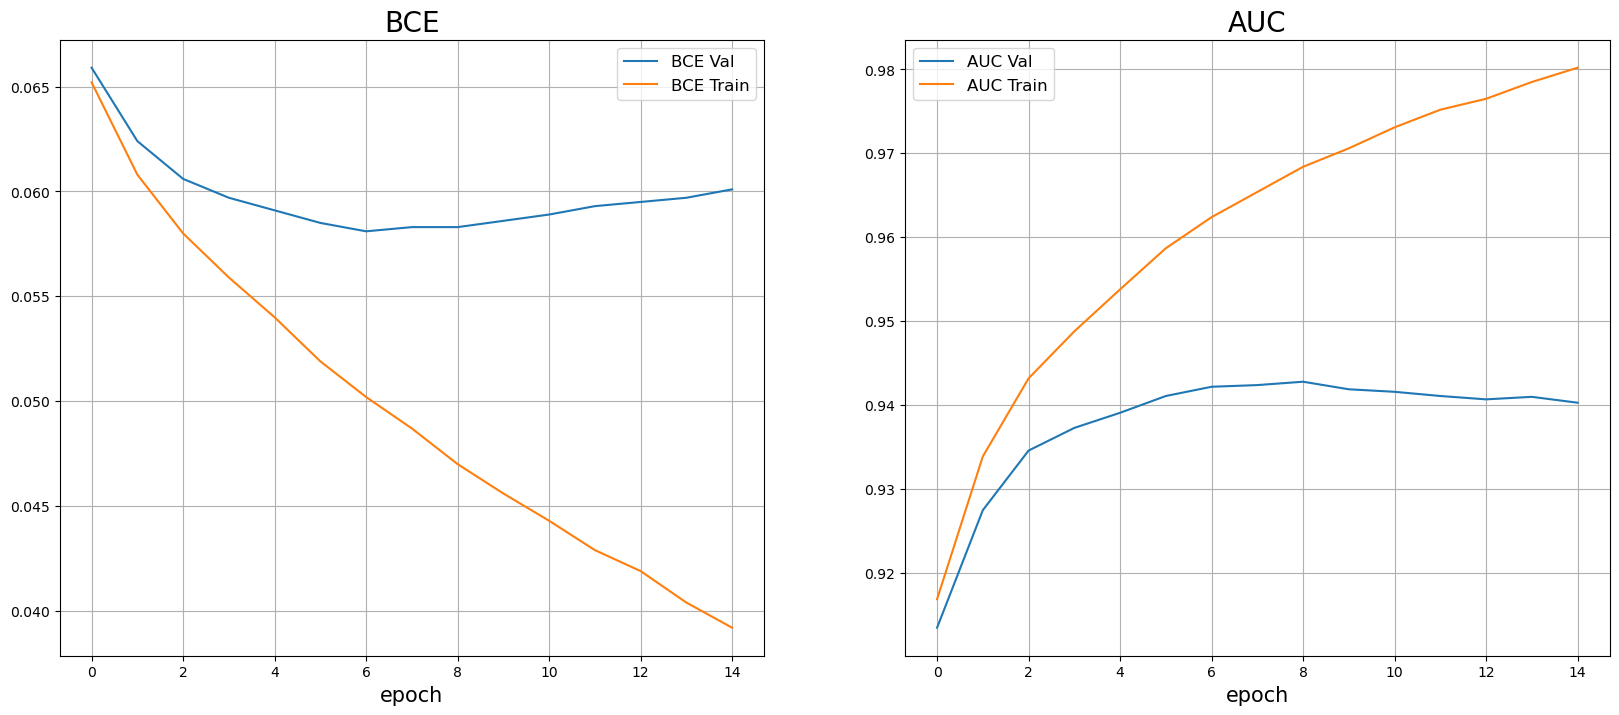

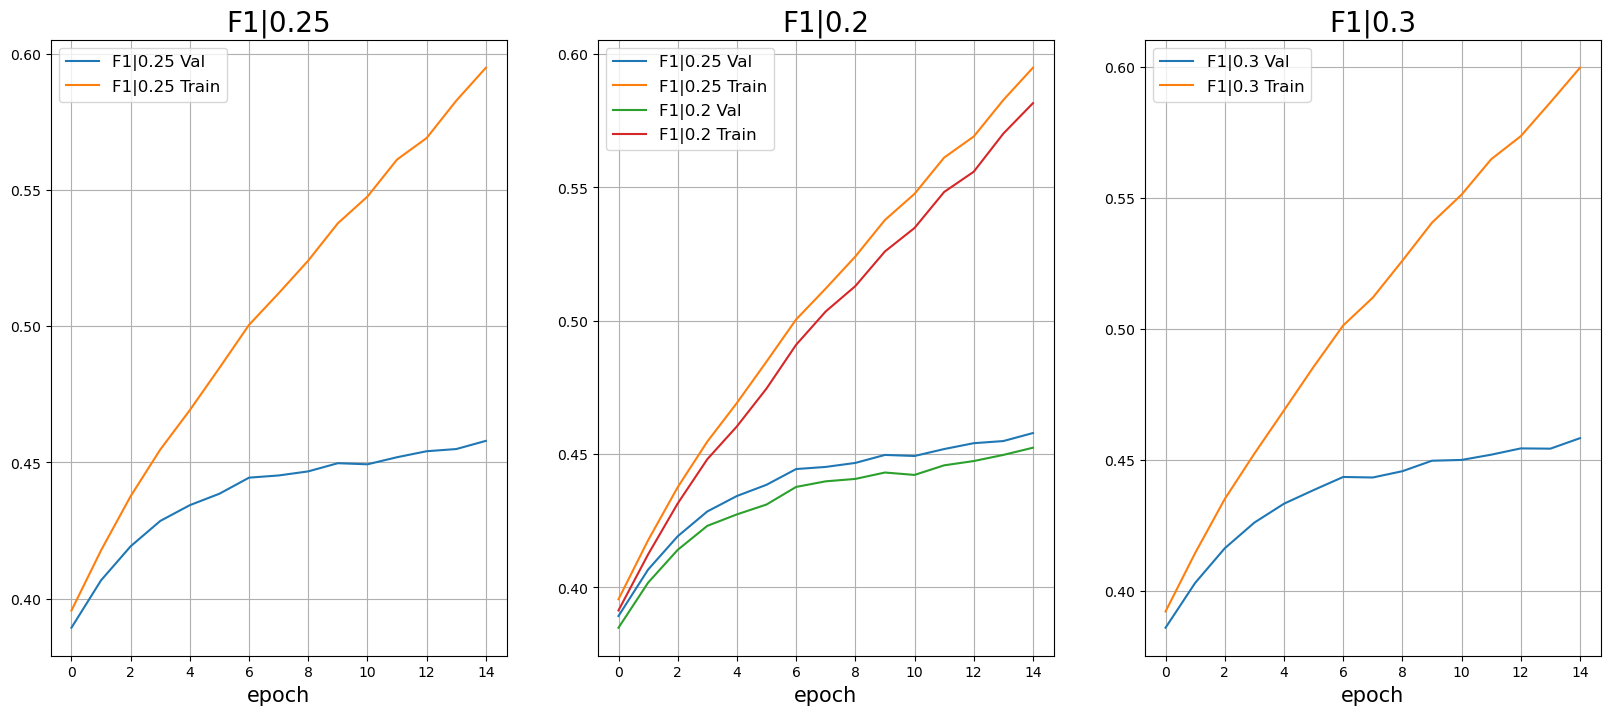

In [21]:
list_metrics_keywords = ['BCE', 'AUC']

plt.figure(figsize = (20,8) )
for i,kw in enumerate(list_metrics_keywords):
    l = [col for col in df_stat if kw in col]
    plt.subplot(1,len(list_metrics_keywords ),i+1)
    plt.plot( df_stat[l], label = l )
    plt.grid()
    plt.legend(fontsize = 12)
    plt.title(kw, fontsize = 20)
    plt.xlabel('epoch',fontsize = 15)
    
plt.show() 

list_metrics_keywords = ['F1|0.25','F1|0.2', 'F1|0.3' ]

plt.figure(figsize = (20,8) )
for i,kw in enumerate(list_metrics_keywords):
    l = [col for col in df_stat if kw in col]
    plt.subplot(1,len(list_metrics_keywords ),i+1)
    plt.plot( df_stat[l], label = l )
    plt.grid()
    plt.legend(fontsize = 12)
    plt.title(kw, fontsize = 20)
    plt.xlabel('epoch',fontsize = 15)
    
plt.show() 

The actual metric in the CAFA5 competition is similar to F1 above, but more sophisticated and computation time is signinificantly large. One may use F1 with threshold around 0.2-0.3 as a kind of "fast-proxi" for it.

The next step to get close to actual CAFA5 metric is to calculate F1 with different thresholds for different subontologies and choose not fixed threhold, but optimal one. Still it would not be exactly CAFA5 F1. Extra steps are: weighting and propagation. We will not go into these details yet.

**Clear memory**

In [22]:
%%time
import gc
if 0:
    del X_train,Y_train, X_val, Y_val, train_dataset, train_dataloader, X, Y
gc.collect()
torch.cuda.empty_cache()

CPU times: user 585 ms, sys: 256 ms, total: 840 ms
Wall time: 845 ms


**Load features for submission**

In [23]:
%%time 
################ load  features #########################

# fn = '/kaggle/input/4637427/train_embeds_esm2_t36_3B_UR50D.npy'
fn = '/kaggle/input/4637427/test_embeds_esm2_t36_3B_UR50D.npy'
print(fn)
X = np.load(fn).astype(np.float32)
print(X.shape)
print(X[:2,:3])


/kaggle/input/4637427/test_embeds_esm2_t36_3B_UR50D.npy
(141865, 2560)
[[ 0.0234699  -0.01637267 -0.00922152]
 [ 0.00416557 -0.03404953 -0.01230596]]
CPU times: user 382 ms, sys: 5.43 s, total: 5.81 s
Wall time: 34.9 s


In [24]:
%%time
X = torch.tensor(X, dtype=torch.float32).to(device)

CPU times: user 394 ms, sys: 1.03 s, total: 1.42 s
Wall time: 758 ms


**Compute Predictions**

In [25]:
%%time
model.eval()
with torch.no_grad():
    preds = model(X)

CPU times: user 18.4 s, sys: 4.65 s, total: 23 s
Wall time: 11.9 s


In [26]:
print(preds.shape)
print(preds[:4,:3])

torch.Size([141865, 1499])
tensor([[0.8791, 0.8274, 0.8691],
        [0.8539, 0.8525, 0.8365],
        [0.8910, 0.7925, 0.8802],
        [0.9056, 0.8230, 0.8972]])


In [27]:
%%time
test_protein_ids = np.load('/kaggle/input/4637427/test_ids_esm2_t36_3B_UR50D.npy')
print(test_protein_ids.shape, test_protein_ids[:10])

(141865,) ['Q9CQV8' 'P62259' 'P68510' 'P61982' 'O70456' 'P68254' 'P63101' 'A2AIG8'
 'Q3UX83' 'Q6PD03']
CPU times: user 2.68 ms, sys: 5.6 ms, total: 8.29 ms
Wall time: 65.2 ms


**Prepare submission file**

In [28]:
%%time
df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])

n_targets_predicted = preds.shape[1]
n_samples_predicted = preds.shape[0]
print('n_samples_predicted, n_targets_predicted',  n_samples_predicted, n_targets_predicted )


protein_list = []
for k in list(test_protein_ids):
    protein_list += [k] * n_targets_predicted
df_submission['Protein Id'] = protein_list

df_submission['GO Term Id'] = list(Y_labels) * n_samples_predicted
df_submission['Prediction'] = preds.ravel()

df_submission = df_submission.round(3)
df_submission = df_submission[ df_submission['Prediction'] > 0.01  ]

memory_usage_per_column = df_submission.memory_usage(deep=True)
total_memory_usage = memory_usage_per_column.sum()
print("\nTotal memory usage:", total_memory_usage/1e6, "Megabytes")

print(df_submission.shape)
display(df_submission)

n_samples_predicted, n_targets_predicted 141865 1499

Total memory usage: 6572.174588 Megabytes
(31900678, 3)


,Protein Id,GO Term Id,Prediction
0,Q9CQV8,GO:0005575,0.879
1,Q9CQV8,GO:0008150,0.827
2,Q9CQV8,GO:0110165,0.869
3,Q9CQV8,GO:0003674,0.769
4,Q9CQV8,GO:0005622,0.755
...,...,...,...
212655473,A0A3G2FQK2,GO:0030246,0.025
212655481,A0A3G2FQK2,GO:1901681,0.026
212655520,A0A3G2FQK2,GO:0061134,0.930
212655591,A0A3G2FQK2,GO:0051346,0.016


CPU times: user 1min 56s, sys: 29.4 s, total: 2min 26s
Wall time: 2min 24s


In [29]:
%%time
import gc
if 0:
    del preds 
    
gc.collect()

df_submission.to_csv("submission.tsv",header=False, index=False,sep='\t')

CPU times: user 2min 11s, sys: 1.32 s, total: 2min 12s
Wall time: 2min 12s


(31900678, 3)


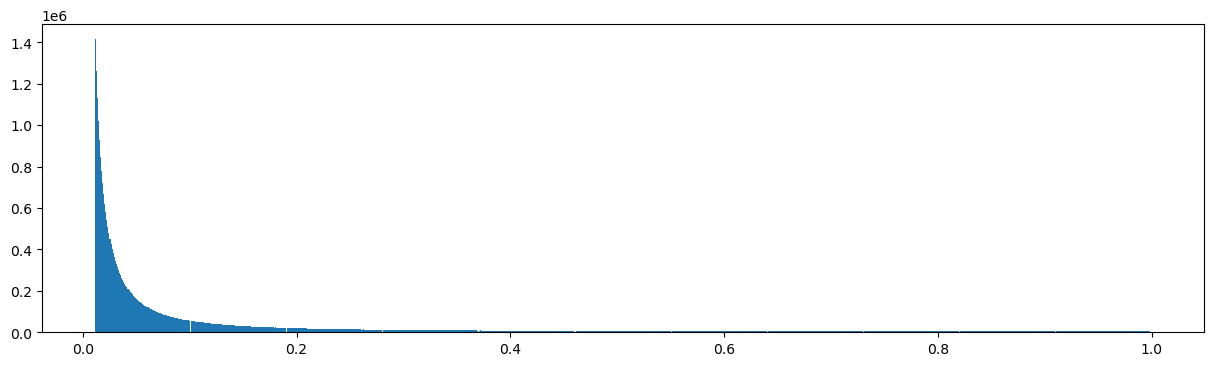

(31900678, 3)


,Prediction
count,3.190068e+07
mean,1.267144e-01
std,2.051429e-01
min,1.100000e-02
25%,1.800000e-02
50%,3.800000e-02
75%,1.170000e-01
max,1.000000e+00


CPU times: user 3.88 s, sys: 320 ms, total: 4.2 s
Wall time: 3.98 s


In [30]:
%%time
print(df_submission.shape)
plt.figure(figsize = (15,4))
plt.hist(df_submission['Prediction'].values, bins = 1000 )
plt.show()
print(df_submission.shape)
display(df_submission.describe())

In [31]:
for t in [0.1,0.2, 0.25,0.28, 0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    m = df_submission['Prediction'] > t
    print(t, m.sum(), m.sum()/ (n_samples_predicted * n_targets_predicted ) )
    
print()    
try:
    print( Y.sum(),  Y.sum()/ (Y.shape[0] * Y.shape[1]) )
except:
    pass    

##print('Here is fast rationale why we should think of threshold for F1 is around 0.28 - number of 1 in that case corresponds to train data')

0.1 8842165 0.041579735237206386
0.2 5567184 0.026179339193151407
0.25 4714493 0.02216961238765199
0.28 4331548 0.020368837157783287
0.3 4098241 0.01927172538832559
0.4 3173094 0.014921278714293182
0.5 2480086 0.01166245136179909
0.6 1916691 0.009013121143016032
0.7 1403125 0.006598108721642857
0.8 928658 0.004366956934858557
0.9 464048 0.002182157082270592
1 0 0.0

4420307.0 0.02073054584885722


In [32]:
print('%.1f seconds passed total '%(time.time()-t0start) )

2959.8 seconds passed total 
